## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-5}~\varepsilon / k_B$;
   - Скорость охлаждения: $v_T = 0.001~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2500$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.size'] = 14

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)

#### Путь к файлам с данными

In [3]:
CURRENT_DATA = '2021-05-18_cooling_slow_1.0'
PLOT_FILENAME_POSTFIX = 'slow_cooling'

In [4]:
PATH_TO_CURRENT_DATA = os.path.join(con.PATH_TO_DATA, CURRENT_DATA)
PATH_TO_CURRENT_DATA

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-18_cooling_slow_1.0'

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA)
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-05-18_cooling_slow_1.0'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
setups = []
for filename in os.listdir(PATH_TO_CURRENT_DATA)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        setups.append(setup)
        
setups

[{'temperature': 0.99962, 'pressure': -2.18977, 'heating_velocity': 0.001},
 {'temperature': 0.99147, 'pressure': 0.73881, 'heating_velocity': 0.001},
 {'temperature': 0.97397, 'pressure': 0.87179, 'heating_velocity': 0.001},
 {'temperature': 0.95924, 'pressure': 0.83907, 'heating_velocity': 0.001},
 {'temperature': 0.94881, 'pressure': 0.76569, 'heating_velocity': 0.001},
 {'temperature': 0.93827, 'pressure': 0.7464, 'heating_velocity': 0.001},
 {'temperature': 0.92279, 'pressure': 0.68198, 'heating_velocity': 0.001},
 {'temperature': 0.9125, 'pressure': 0.63237, 'heating_velocity': 0.001},
 {'temperature': 0.901, 'pressure': 0.59552, 'heating_velocity': 0.001},
 {'temperature': 0.88477, 'pressure': 0.47197, 'heating_velocity': 0.001},
 {'temperature': 0.87425, 'pressure': 0.55982, 'heating_velocity': 0.001},
 {'temperature': 0.86189, 'pressure': 0.48779, 'heating_velocity': 0.001},
 {'temperature': 0.85094, 'pressure': 0.48688, 'heating_velocity': 0.001},
 {'temperature': 0.83768, 'p

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_temperatures = (0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-4)

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
pp = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX, 
    setups=setups,
)
pp.rdf.data

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,setup_9,setup_10,setup_11,setup_12,setup_13,setup_14,setup_15,setup_16
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,1.000569,1.003953,1.001820,1.002352,1.006180,1.003339,1.002689,1.002552,1.004018,1.002924,1.003147,1.003989,1.003036,1.002994,1.003311,1.004614,1.004880
608,6.09,1.000721,1.004857,1.003524,1.001274,1.004060,1.004222,1.004005,1.002414,1.003125,1.001963,1.003964,1.003172,1.003457,1.003213,1.001762,1.004606,1.004460
609,6.10,0.999524,1.004392,1.002911,1.001973,1.003346,1.004989,1.003450,1.002458,1.005793,1.001820,1.002658,1.003327,1.002336,1.003100,1.000828,1.005009,1.004537
610,6.11,1.000953,1.004796,1.001957,1.004307,1.003266,1.004559,1.004169,1.002582,1.005550,1.002121,1.002672,1.002235,1.004080,1.004608,1.003652,1.005762,1.003757


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

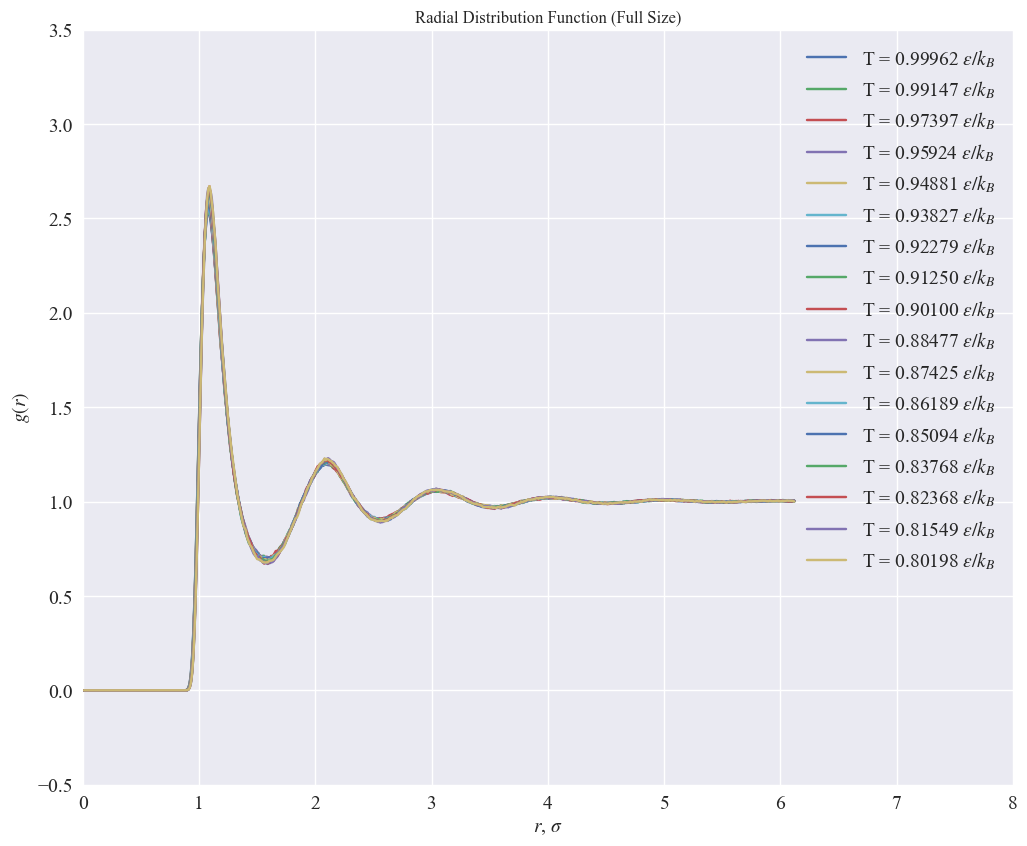

In [11]:
pp.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=3.5,
    figsize=(12, 10),
    title='Radial Distribution Function (Full Size)',
    filename_postfix='full_size',
)

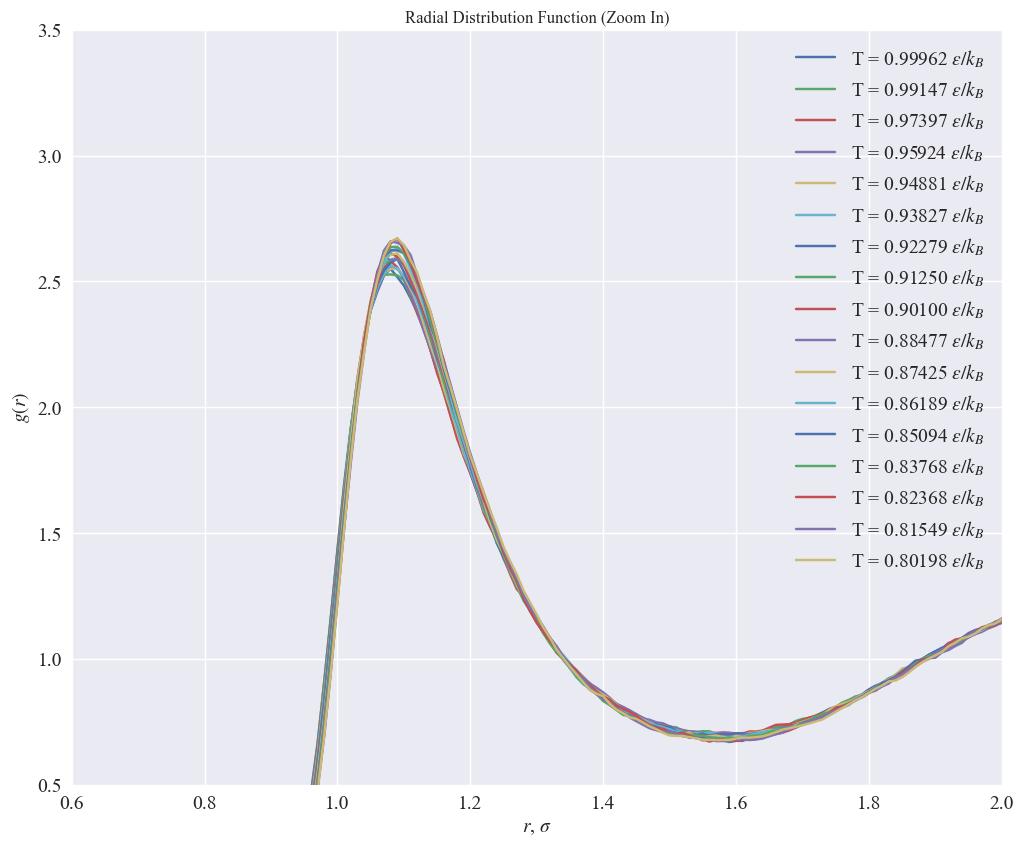

In [12]:
pp.plot_rdf(
    shift=0.0,
    left=0.6, 
    right=2,
    bottom=0.5,
    top=3.5, 
    figsize=(12, 10),
    title='Radial Distribution Function (Zoom In)',
    filename_postfix='zoom_in',
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [13]:
rr = RegressionRDF(
    post_processor=pp, 
    setups=setups,
    test_temperatures=test_temperatures,
)
rdf_table = rr.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003486,1.004133,1.003933,1.006119,1.004487,1.004880,1.004460,1.004537,1.003757,1.000341
setup_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005108,1.003812,1.002735,1.003844,1.006285,1.004614,1.004606,1.005009,1.005762,1.003415
setup_14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004991,1.003790,1.002304,1.003654,1.000273,1.003311,1.001762,1.000828,1.003652,1.003145
setup_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004422,1.004607,1.002599,1.003358,1.003865,1.002994,1.003213,1.003100,1.004608,1.002655
setup_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004327,1.003933,1.004211,1.003829,1.002880,1.003036,1.003457,1.002336,1.004080,1.004118
setup_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003151,1.004358,1.004129,1.004579,1.005662,1.003989,1.003172,1.003327,1.002235,1.001439
setup_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001717,1.005347,1.005194,1.003608,1.003651,1.003147,1.003964,1.002658,1.002672,1.002286
setup_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002760,1.002860,1.002282,1.002925,1.000064,1.002924,1.001963,1.001820,1.002121,1.002337
setup_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003192,1.004340,1.005415,1.004854,1.005265,1.004018,1.003125,1.005793,1.005550,1.004314
setup_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002083,1.002974,1.002085,1.002437,1.004930,1.002552,1.002414,1.002458,1.002582,1.001941


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [14]:
predicted_points = rr.run_linear_regressions(
    is_printed=True,
    is_plotted=False,
)

r = 0.87; k =  0.00022; b = -0.00019; RMSE = 0.00002
r = 0.88; k =  0.00192; b = -0.00159; RMSE = 0.00008
r = 0.89; k =  0.00559; b = -0.00434; RMSE = 0.00016
r = 0.90; k =  0.01859; b = -0.01389; RMSE = 0.00039
r = 0.91; k =  0.05330; b = -0.03888; RMSE = 0.00082
r = 0.92; k =  0.13105; b = -0.09255; RMSE = 0.00100
r = 0.93; k =  0.26121; b = -0.17427; RMSE = 0.00236
r = 0.94; k =  0.44871; b = -0.27889; RMSE = 0.00295
r = 0.95; k =  0.66396; b = -0.37021; RMSE = 0.00326
r = 0.96; k =  0.88490; b = -0.42145; RMSE = 0.00395
r = 0.97; k =  1.01331; b = -0.34549; RMSE = 0.00511
r = 0.98; k =  1.14408; b = -0.22836; RMSE = 0.00736
r = 0.99; k =  1.18049; b =  0.00042; RMSE = 0.00859
r = 1.00; k =  1.11938; b =  0.33019; RMSE = 0.00907
r = 1.01; k =  0.94595; b =  0.75935; RMSE = 0.00912
r = 1.02; k =  0.73425; b =  1.19695; RMSE = 0.01202
r = 1.03; k =  0.41639; b =  1.70582; RMSE = 0.01453
r = 1.04; k =  0.18093; b =  2.09626; RMSE = 0.01429
r = 1.05; k = -0.04989; b =  2.44723; RMSE = 0

r = 3.34; k =  0.00472; b =  0.99423; RMSE = 0.00249
r = 3.35; k =  0.00849; b =  0.98782; RMSE = 0.00272
r = 3.36; k =  0.01602; b =  0.97862; RMSE = 0.00213
r = 3.37; k =  0.02747; b =  0.96654; RMSE = 0.00172
r = 3.38; k =  0.02445; b =  0.96661; RMSE = 0.00181
r = 3.39; k =  0.02791; b =  0.96164; RMSE = 0.00257
r = 3.40; k =  0.01146; b =  0.97412; RMSE = 0.00251
r = 3.41; k =  0.00765; b =  0.97561; RMSE = 0.00216
r = 3.42; k = -0.00432; b =  0.98469; RMSE = 0.00278
r = 3.43; k =  0.01344; b =  0.96730; RMSE = 0.00277
r = 3.44; k =  0.02109; b =  0.95801; RMSE = 0.00262
r = 3.45; k =  0.02911; b =  0.94977; RMSE = 0.00244
r = 3.46; k =  0.03590; b =  0.94291; RMSE = 0.00249
r = 3.47; k =  0.03167; b =  0.94587; RMSE = 0.00296
r = 3.48; k =  0.03042; b =  0.94611; RMSE = 0.00365
r = 3.49; k =  0.01508; b =  0.95859; RMSE = 0.00335
r = 3.50; k =  0.01757; b =  0.95538; RMSE = 0.00322
r = 3.51; k =  0.01062; b =  0.96084; RMSE = 0.00336
r = 3.52; k =  0.03369; b =  0.93979; RMSE = 0

r = 5.67; k = -0.00054; b =  1.00097; RMSE = 0.00096
r = 5.68; k =  0.00745; b =  0.99365; RMSE = 0.00110
r = 5.69; k =  0.00069; b =  1.00008; RMSE = 0.00130
r = 5.70; k =  0.01185; b =  0.99041; RMSE = 0.00171
r = 5.71; k =  0.00001; b =  1.00090; RMSE = 0.00180
r = 5.72; k = -0.00579; b =  1.00673; RMSE = 0.00156
r = 5.73; k = -0.00321; b =  1.00472; RMSE = 0.00123
r = 5.74; k = -0.00418; b =  1.00542; RMSE = 0.00147
r = 5.75; k = -0.00593; b =  1.00718; RMSE = 0.00162
r = 5.76; k =  0.00396; b =  0.99817; RMSE = 0.00163
r = 5.77; k =  0.00034; b =  1.00190; RMSE = 0.00171
r = 5.78; k = -0.00187; b =  1.00365; RMSE = 0.00149
r = 5.79; k = -0.00205; b =  1.00407; RMSE = 0.00186
r = 5.80; k =  0.00275; b =  0.99988; RMSE = 0.00195
r = 5.81; k =  0.00493; b =  0.99795; RMSE = 0.00152
r = 5.82; k = -0.00384; b =  1.00607; RMSE = 0.00154
r = 5.83; k = -0.00385; b =  1.00577; RMSE = 0.00137
r = 5.84; k =  0.00274; b =  1.00028; RMSE = 0.00126
r = 5.85; k =  0.00145; b =  1.00189; RMSE = 0

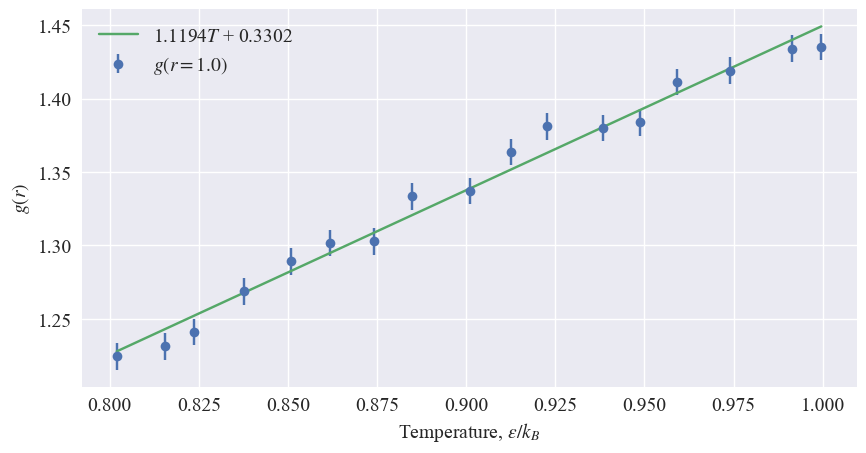

In [15]:
for column in (1.0, ):
    y = rr.rdf_table[column]
    k, b, fitted_data, error = rr.get_fitted_column(y_train=y)
    rr.plot_linear_regression(
        y_train=y,
        fitted_data=fitted_data,
        error=error,
        k=k, b=b, r=column,
        is_saved=True,
    )
    plt.close()

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

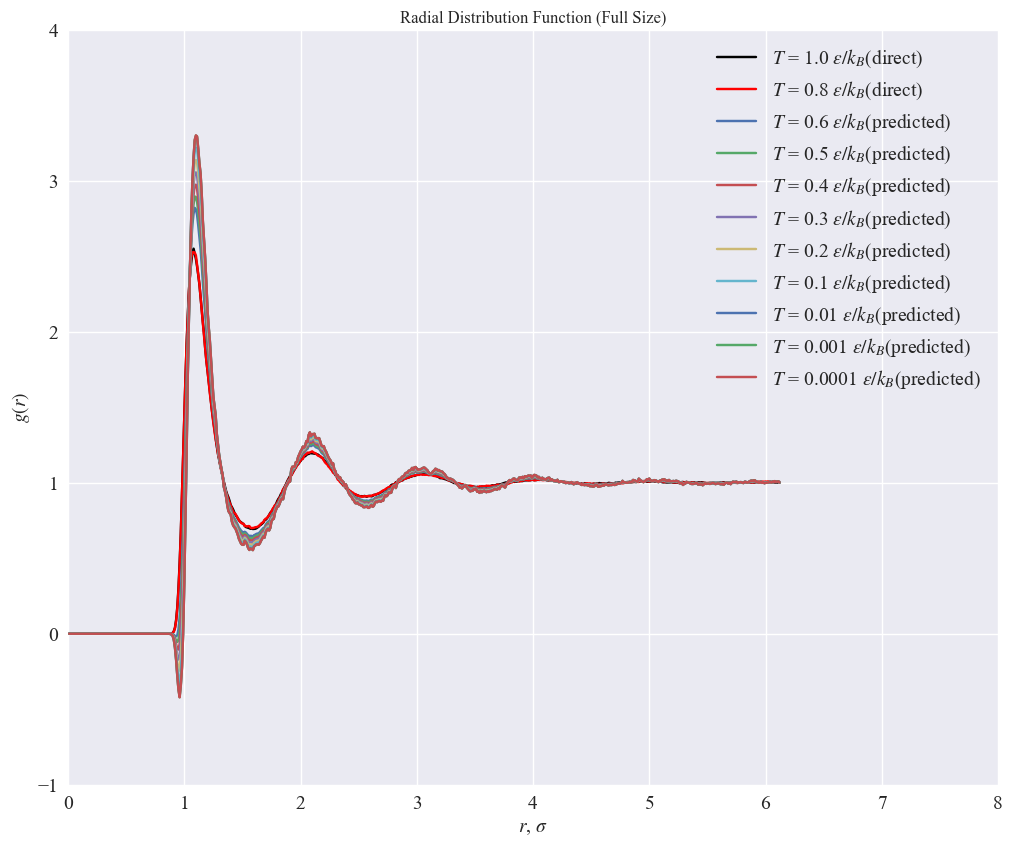

In [16]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, setup in enumerate((setups[0], setups[-1])):
    temperature = setup["temperature"]
    current_rdf = pp.rdf.data[f'setup_{i}']
    ax.plot(
        pp.rdf.data['radius'],
        current_rdf,
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
#     for i, r in enumerate(rdf_table.columns.values):
#         if value[i] < 0:
#             print(r, value[i])
#     print()
    ax.plot(rdf_table.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-1, 
    top=4,
);
ax.set_title('Radial Distribution Function (Full Size)')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')

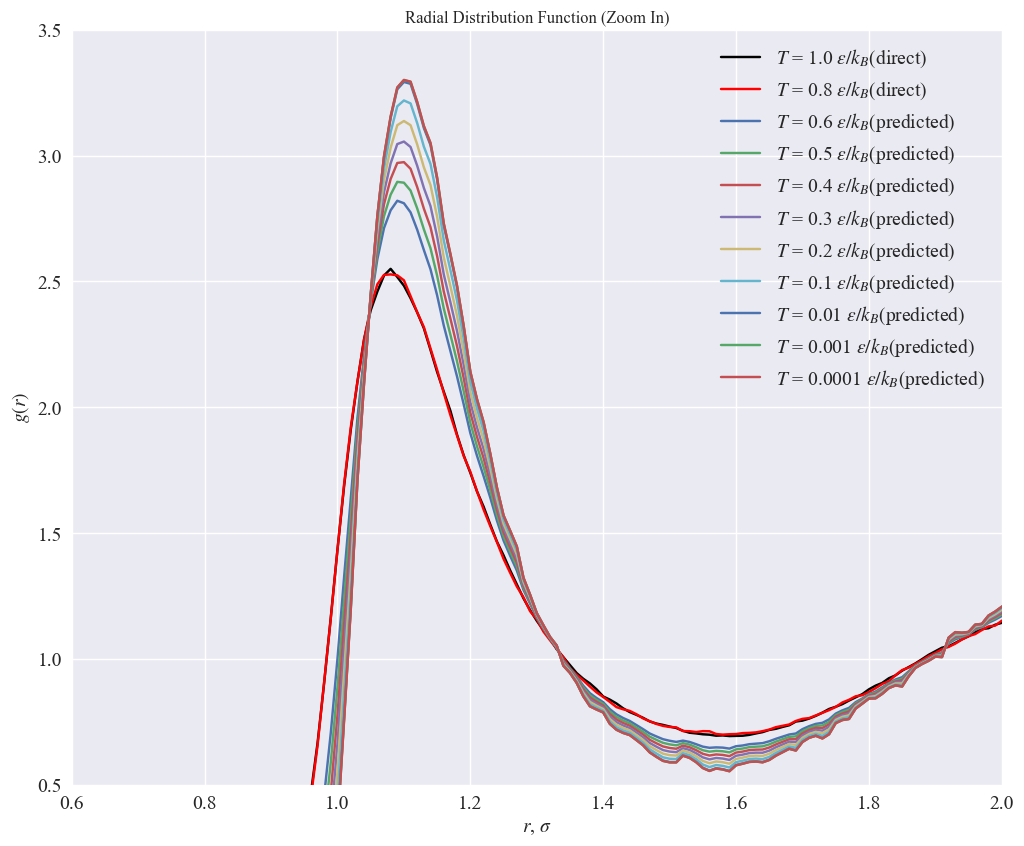

In [17]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, setup in enumerate((setups[0], setups[-1])):
    temperature = setup["temperature"]
    current_rdf = pp.rdf.data[f'setup_{i}']
    ax.plot(
        pp.rdf.data['radius'],
        current_rdf,
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
#     for i, r in enumerate(rdf_table.columns.values):
#         if value[i] < 0:
#             print(r, value[i])
#     print()
    ax.plot(rdf_table.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=0.5, 
    top=3.5,
);
ax.set_title('Radial Distribution Function (Zoom In)')
ax.legend();

save_plot(f'rdf_with_predicted_zoom_in_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость среднеквадратичного смещения $\left<\Delta r^2(t)\right>$ при различных температурах

$$\left<\Delta r^2(t)\right>=\dfrac{1}{N}\sum_{i=1}^{N}{\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2}$$

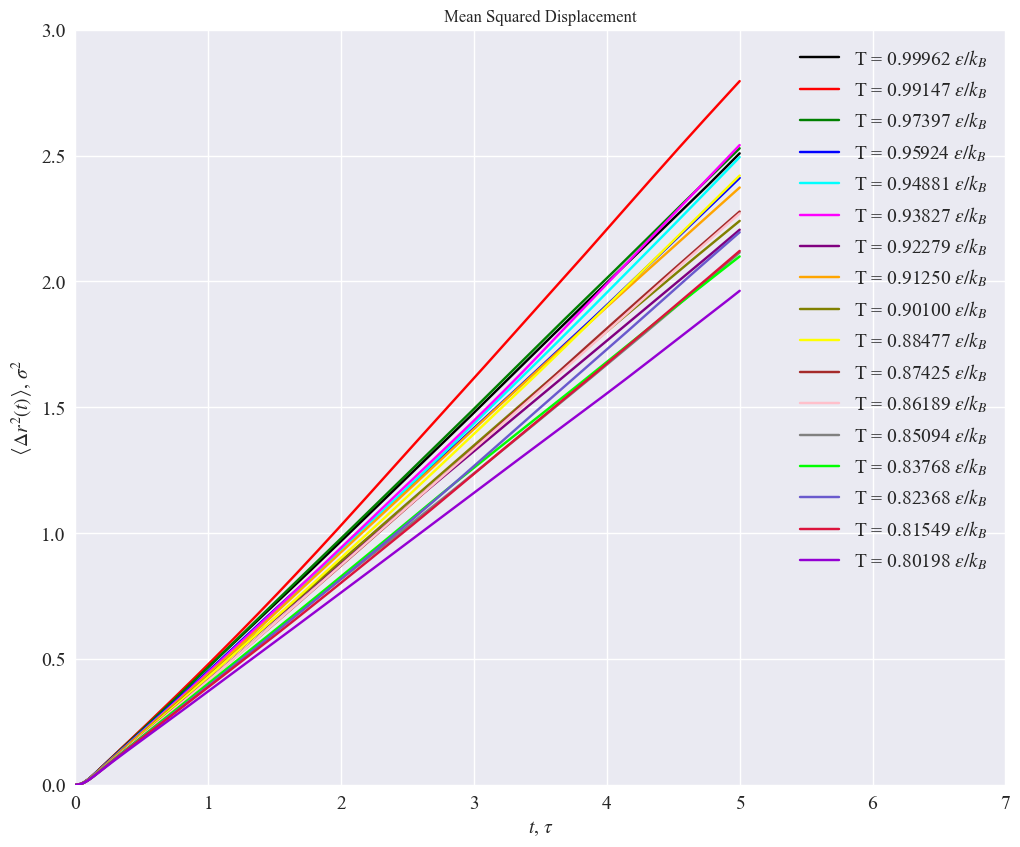

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, setup in enumerate(setups):
    ax.plot(
        pp.msd.data['time'],
        pp.msd.data[f'setup_{i}'], 
        label=f'T = {setup["temperature"]:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel(r'$t$, $\tau $');
ax.set_ylabel(r'$\left<\Delta r^2(t)\right>$, $\sigma^2$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=3,
);
ax.set_title('Mean Squared Displacement');
ax.legend();

save_plot(f'msd_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Эйнштейна, при различных температурах

$$D_E(t)=\dfrac{\left<\left<\Delta r^2\right>\right>}{6t}=\dfrac{1}{6tN}\left<\sum_{i=1}^{N}\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2\right>$$

$$D=\lim_{t\rightarrow\infty}{D_E(t)}$$

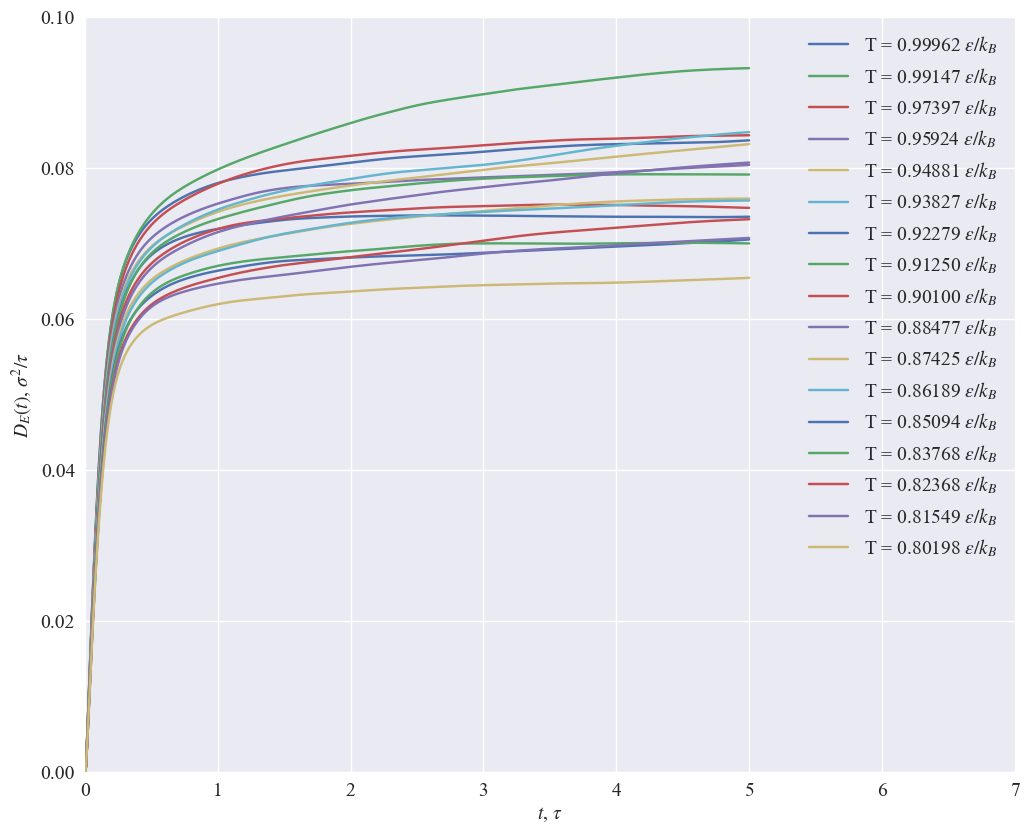

In [19]:
pp.plot_einstein_diffusion(
    left=0,
    right=7,
    bottom=0, 
    top=0.10,
    figsize=(12, 10),
)

#### Температурная зависимость коэффициентов самодиффузии, вычисленных через соотношения Эйнштейна

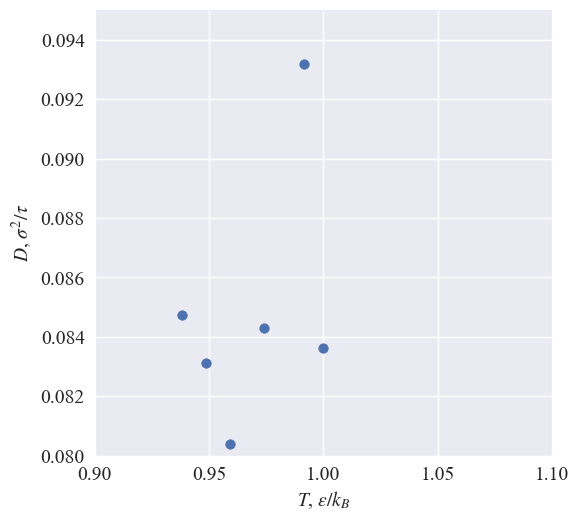

In [20]:
pp.plot_diffusion(
    left=0.9, 
    right=1.1,
    bottom=0.08, 
    top=0.095,
)

k = 0.098; b = -0.010; RMSE = 0.003


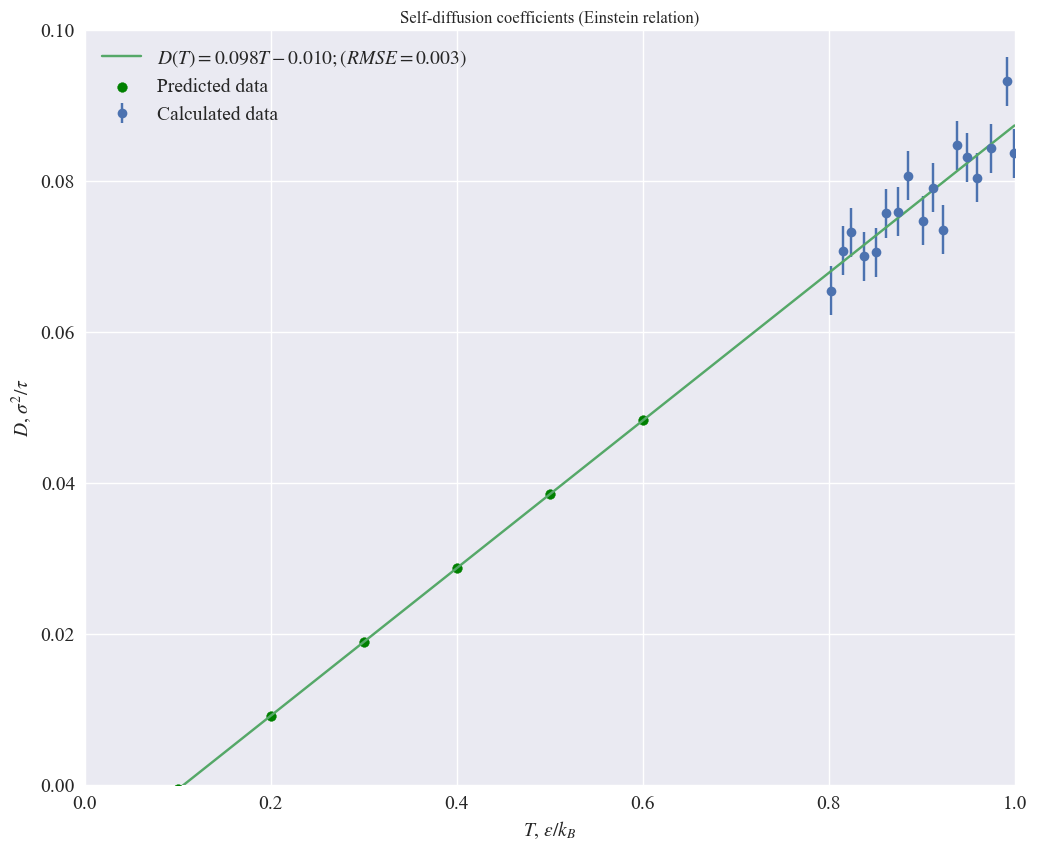

In [21]:
predicted_points = {key: [] for key in test_temperatures}

test_temperatures = np.array(test_temperatures)
temperatures = [setup['temperature'] for setup in setups]
x = np.array(temperatures, dtype=np.float32)
y = pp.diffusion_coefficients

regressor = LinearRegression()
regressor.fit(x.reshape((x.size, 1)), y)
k = regressor.coef_[0]
b = regressor.intercept_
training_data = k * x + b
rmse = mean_squared_error(y, training_data, squared=False)

for key, _ in predicted_points.items():
    predicted_points[key].append(k * key + b)
print(f'k = {k:5.3f}; b = {b:5.3f}; RMSE = {rmse:.3f}')

fig, ax = plt.subplots(figsize=(12, 10));
ax.set_title(f"Self-diffusion coefficients (Einstein relation)");
ax.errorbar(x, y, yerr=rmse, fmt='o', label='Calculated data');
ax.scatter(test_temperatures, k * test_temperatures + b, label='Predicted data', color='green');
x = np.linspace(0, x.max(), 10)
ax.plot(x, k * x + b, label=fr'$D(T) = {k:.3f}T {"+" if b >= 0 else "-"} {abs(b):.3f}; (RMSE = {rmse:.3f})$');
ax.set_xlabel(r'$T$, $\epsilon / k_B $');
ax.set_ylabel(r'$D$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0, 
    right=1,
);
ax.set_ylim(
    bottom=0, 
    top=0.10,
);
ax.legend(markerscale=1);
save_plot(f"diffusion_einstein_fitted_{PLOT_FILENAME_POSTFIX}.png")
plt.show();

#### Вычисление термодинамических функций

In [22]:
pp.get_enthalpy();
pp.get_entropy();
pp.get_free_energy();
pp.get_gibbs_energy();

#### Зависимость энтропии системы от времени

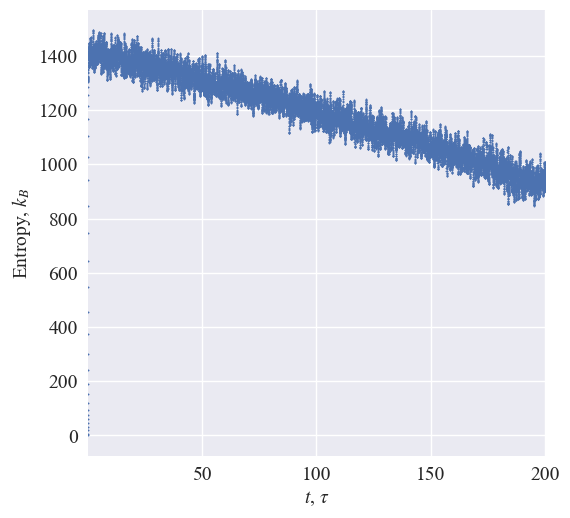

In [23]:
pp.plot_system_parameters(
    column_names=['entropy', ],
    y_label=r'Entropy, $k_B$',
#     bottom=-2,
#     top=2,
);

#### Зависимость энтальпии, внутренней энергии, свободной энергии Гельмгольца и энергии Гиббса от времени

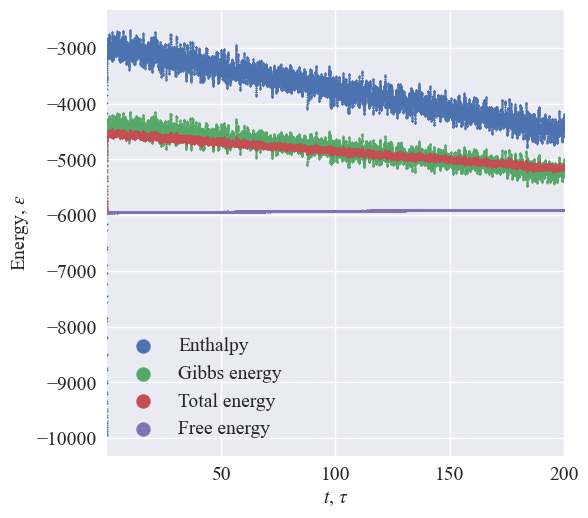

In [24]:
pp.plot_system_parameters(
    column_names=[
        'enthalpy', 
        'gibbs_energy', 
        'total_energy', 
        'free_energy',
    ],
    y_label=r'Energy, $\epsilon$',
    file_name_prefix='all_thermodynamic_functions',
#     bottom=100,
#     top=2000,
);

#### Зависимость внутренней энергии системы от энтропии

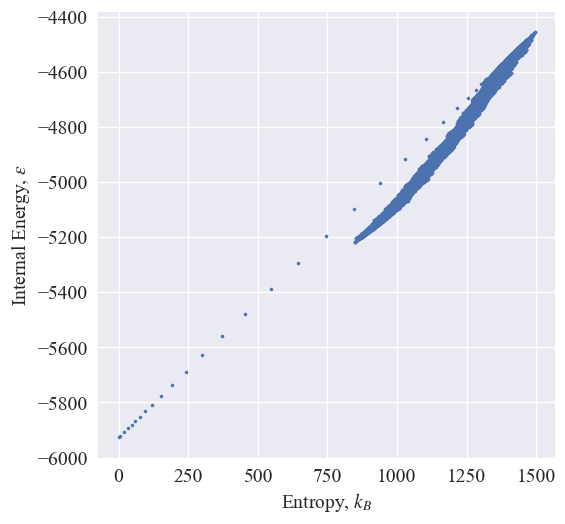

In [25]:
plt.scatter(pp.system_parameters['entropy'], pp.system_parameters['total_energy'], s=5);
plt.xlabel(r'Entropy, $k_B $',)
plt.ylabel(r'Internal Energy, $\epsilon$',)
plt.show();

#### Зависимость внутренней энергии системы от объёма

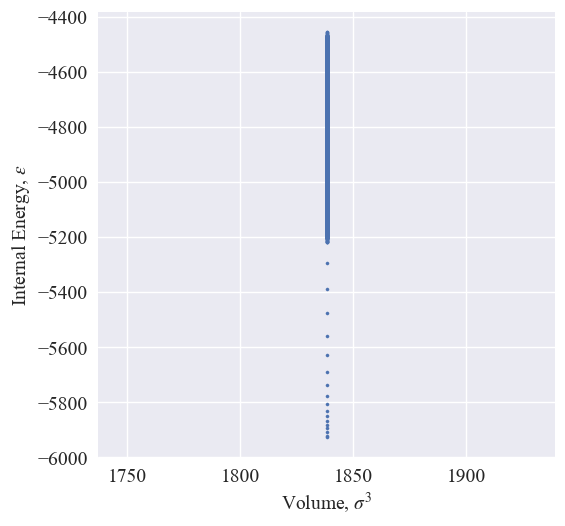

In [26]:
plt.scatter(pp.system_parameters['volume'], pp.system_parameters['total_energy'], s=5);
plt.xlabel(r'Volume, $\sigma^3 $',)
plt.ylabel(r'Internal Energy, $\epsilon$',)
plt.show();

#### Зависимость энтальпии системы от энтропии

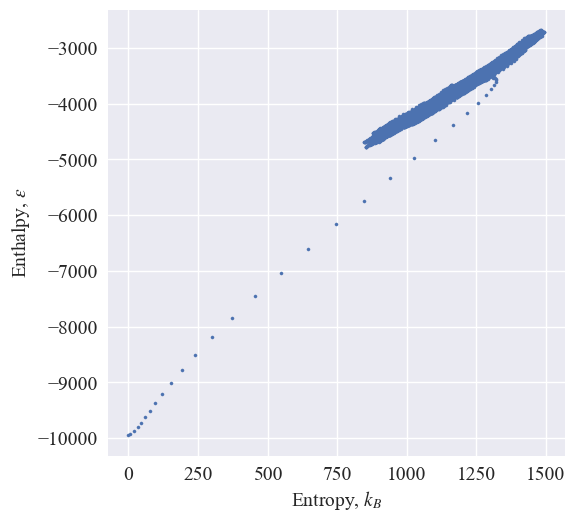

In [27]:
plt.scatter(pp.system_parameters['entropy'], pp.system_parameters['enthalpy'], s=5);
plt.xlabel(r'Entropy, $k_B $',)
plt.ylabel(r'Enthalpy, $\epsilon$',)
plt.show();

#### Зависимость энтальпии системы от давления

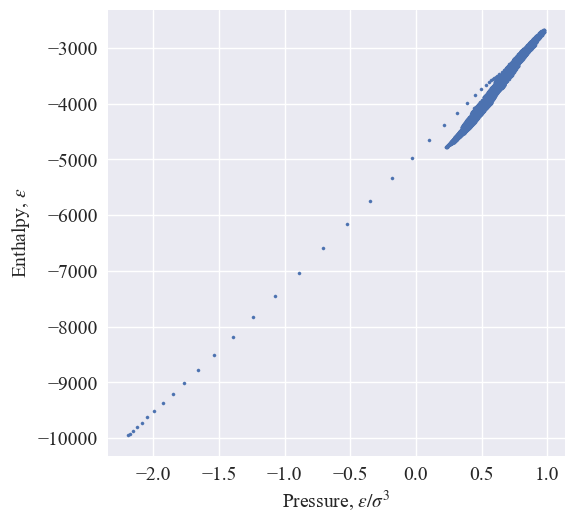

In [28]:
plt.scatter(pp.system_parameters['pressure'], pp.system_parameters['enthalpy'], s=5);
plt.xlabel(r'Pressure, $\epsilon / \sigma^3 $')
plt.ylabel(r'Enthalpy, $\epsilon$')
plt.show();

#### Зависимость свободной энергии Гельмгольца от объёма системы

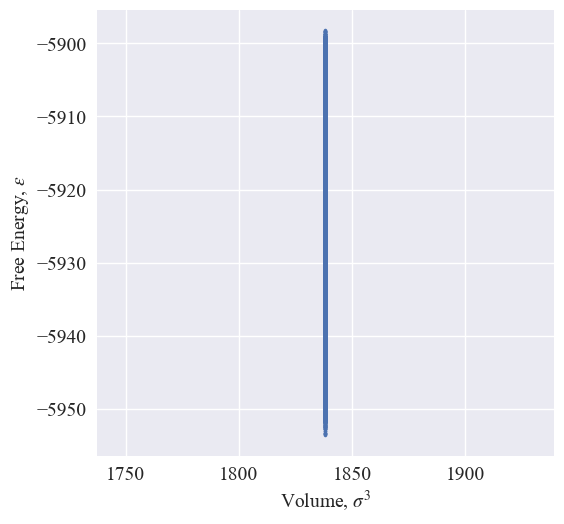

In [29]:
plt.scatter(pp.system_parameters['volume'], pp.system_parameters['free_energy'], s=5);
plt.xlabel(r'Volume, $\sigma^3 $',)
plt.ylabel(r'Free Energy, $\epsilon$',)
plt.show();

#### Зависимость свободной энергии Гельмгольца от температуры системы

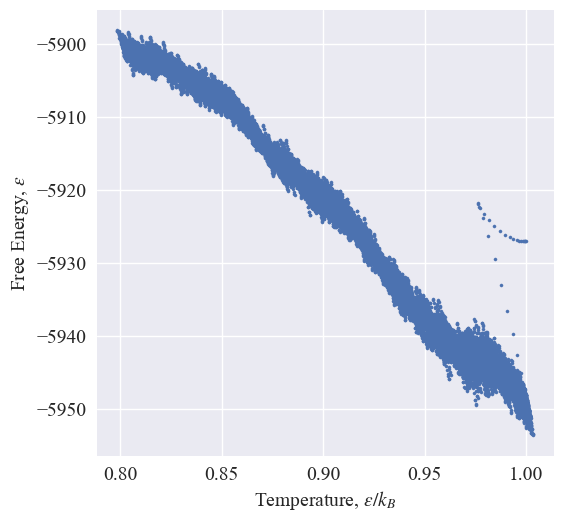

In [30]:
plt.scatter(pp.system_parameters['temperature'], pp.system_parameters['free_energy'], s=5);
plt.xlabel(r'Temperature, $\epsilon/k_B $',)
plt.ylabel(r'Free Energy, $\epsilon$',)
plt.show();

#### Зависимость энергии Гиббса от температуры системы

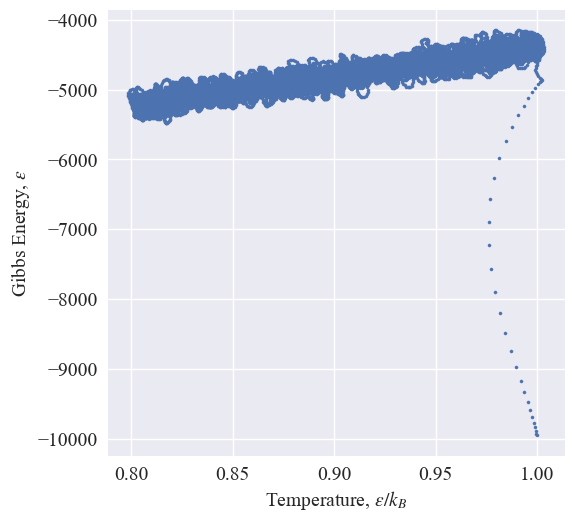

In [31]:
plt.scatter(pp.system_parameters['temperature'], pp.system_parameters['gibbs_energy'], s=5);
plt.xlabel(r'Temperature, $\epsilon/k_B $',)
plt.ylabel(r'Gibbs Energy, $\epsilon$',)
plt.show();

#### Зависимость энергии Гиббса от давления системы

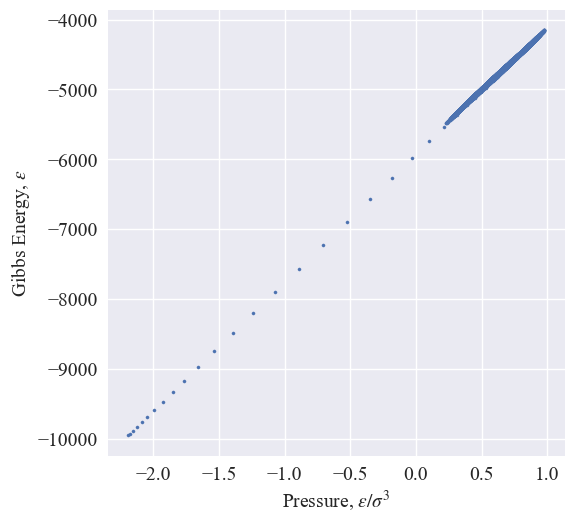

In [32]:
plt.scatter(pp.system_parameters['pressure'], pp.system_parameters['gibbs_energy'], s=5);
plt.xlabel(r'Pressure, $\epsilon / \sigma^3 $')
plt.ylabel(r'Gibbs Energy, $\epsilon$',)
plt.show();